In [1]:
from preprocessing import FeatExtractor
from utils import SlidingWindow, generate_heatmap, detect_vehicles, draw_labeled_bboxes
from learning import LinearSVM

import pickle
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading images

#### Here I load the images of vehicles and non-vehicles from the standard data set. Some examples are plotted below

In [2]:
path = "data/vehicles/*/*.png"
vehicles = glob.glob(path)

path = "data/non-vehicles/*/*.png"
non_vehicles = glob.glob(path)

In [3]:
images_vehicles = np.array([255*mpimg.imread(v) for v in vehicles])
images_nonvehicles = np.array([255*mpimg.imread(nv) for nv in non_vehicles])
y = np.concatenate([np.ones((images_vehicles.shape[0])), np.zeros((images_nonvehicles.shape[0]))]).reshape((-1,1))
images = np.concatenate([images_vehicles, images_nonvehicles], axis=0)

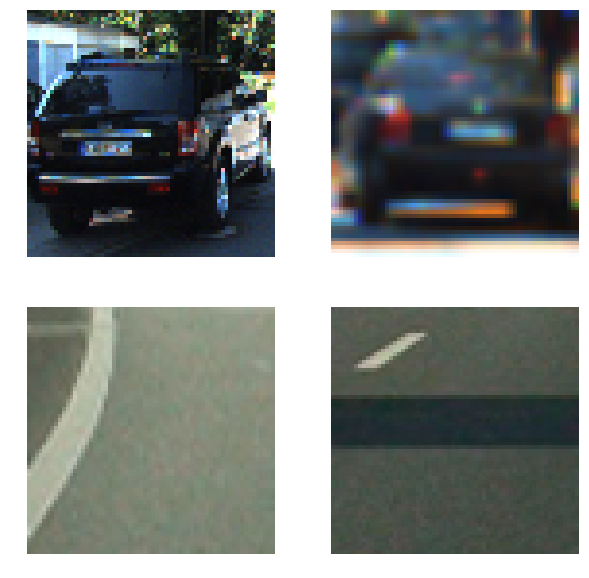

In [4]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(images_vehicles[6]/255)
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(images_vehicles[1]/255)
plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(images_nonvehicles[1]/255)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(images_nonvehicles[6]/255)
plt.savefig("data/report_images/examples_images.jpg")
plt.show()

### Loading Udacity images

#### In some cases the pipeline below failed to recognise cars. The reason may be due that in the standard dataset there are only images of cars taken from behind. For this reason I provide a small data augmentation protocol. The new images from cars are taken from the Udacity dataset randomly. In order not to unbalance the dataset I use only 500 images resized to 64x64 pixels, and I add them to the previous ones.

In [5]:
csv_info = "data/labels_udacity.csv"
csv_info = pd.read_csv(csv_info).drop(["Preview URL"],1)
cars_udacity = csv_info[csv_info["Label"]=="Car"]
cars_udacity.head(4)

xmin  ymin  xmax  ymax                    Frame Label
0   785   533   905   644  1479498371963069978.jpg   Car
1    89   551   291   680  1479498371963069978.jpg   Car
2   268   546   383   650  1479498371963069978.jpg   Car
5  1726   484  1919   646  1479498371963069978.jpg   Car

In [6]:
sample_cars = cars_udacity.sample(500)

images_udacity = []
y_udacity = []
for index in sample_cars.index:
    path = "data/udacity/" + str(sample_cars.ix[index, 'Frame'])
    xmin = sample_cars.ix[index, 'xmin']
    xmax = sample_cars.ix[index, 'xmax']
    ymin = sample_cars.ix[index, 'ymin']
    ymax = sample_cars.ix[index, 'ymax']
    image = mpimg.imread(path)[ymin:ymax,xmin:xmax]
    image = cv2.resize(image, dsize=(64,64))
    images_udacity.append(image)
    y_udacity.append(1)
images_udacity = np.array(images_udacity)
y_udacity = np.array(y_udacity).reshape((-1,1))



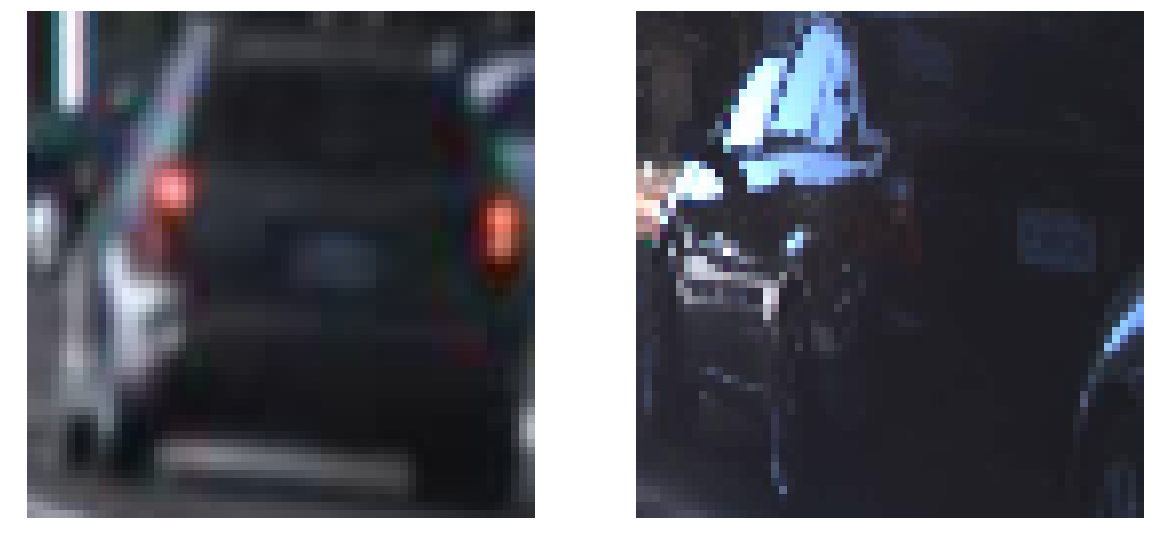

In [13]:
plt.figure(figsize=(20,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(images_udacity[100])
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(images_udacity[69])
plt.savefig("data/report_images/examples_images_udacity.jpg")

In [8]:
images = np.concatenate([images, images_udacity], axis=0)
y = np.concatenate([y,y_udacity])

## Feature extraction

#### In this section feature extraction is implemented. I consider HOG features, color channel histogram features and spatial bin features. (See the script files for the implementation of the extraction functions)

In [9]:
def extract_hog(image):
    image_color = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return FeatExtractor.extract_HOG(image_color, orient=9, cell_per_block=2, pix_per_cell=8, visualize=False)

def extract_channel_hist(image):
    return FeatExtractor.extract_COLOR_Histograms(image, nbins=32)

def extract_spatial_bin(image):
    return FeatExtractor.extract_spatial_bin(image, size=(32, 32))

X_SB = np.array([extract_spatial_bin(im) for im in images])
X_HOG = np.array([extract_hog(im) for im in images])
X_CH = np.array([extract_channel_hist(im) for im in images])

#### Here below we show examples of HOG features extracted from the three channels of color space YCrCb. The first is for a car image, the second for a non car image

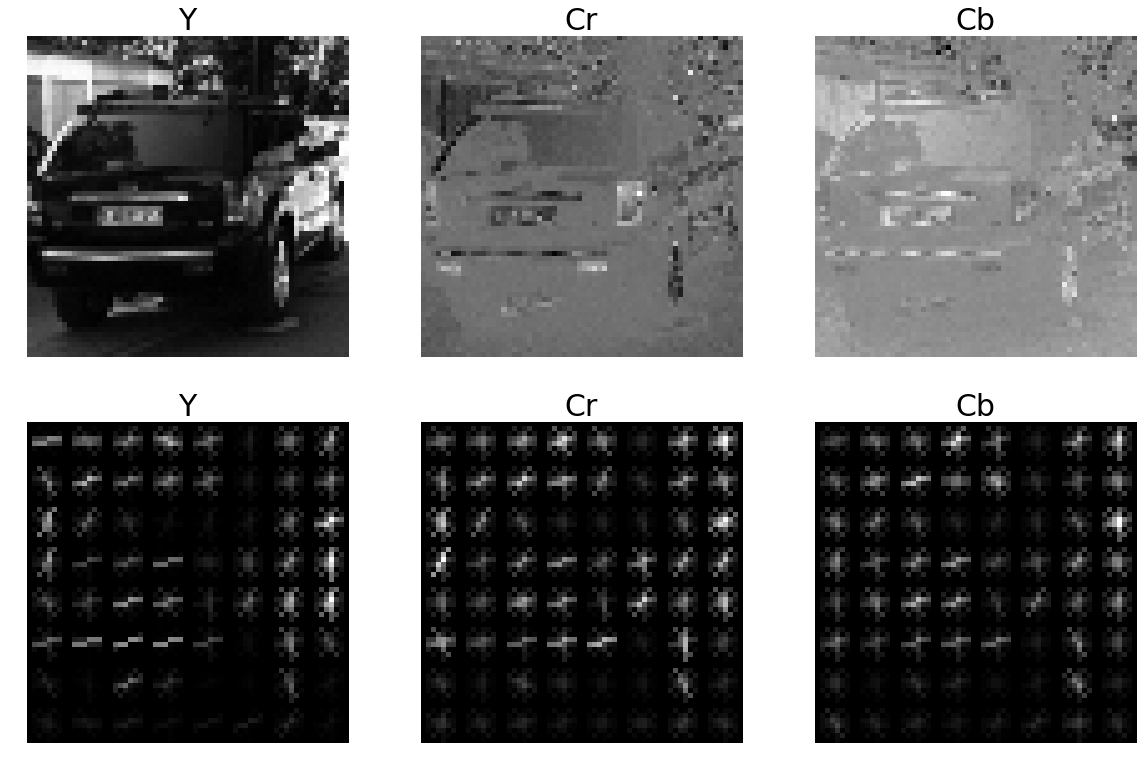

In [4]:
image = images_vehicles[6]/255
image_color = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

channel = ["Y", "Cr", "Cb"]
plt.figure(figsize=(20,13))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.title(channel[i], fontsize=30)
    plt.axis("off")
    plt.imshow(image_color[:,:,i], cmap="gray")

feat, image_HOG = FeatExtractor.extract_HOG(image_color, orient=9, cell_per_block=2, pix_per_cell=8, visualize=True)
for i in range(3):
    plt.subplot(2,3,3+i+1)
    plt.title(channel[i], fontsize=30)
    plt.axis("off")
    plt.imshow(image_HOG[:,:,i]*255, cmap="gray")

plt.savefig("data/report_images/HOG_feature_vehicle.jpg")

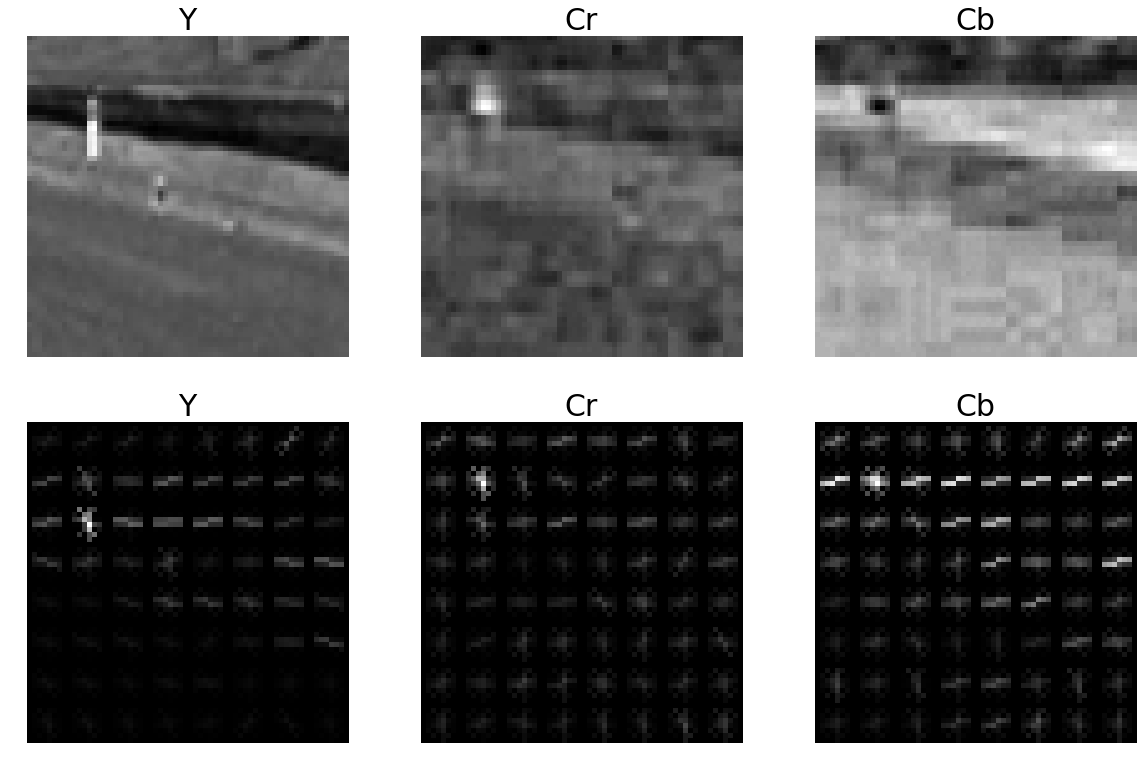

In [8]:
image = images_nonvehicles[9]/255
image_color = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

channel = ["Y", "Cr", "Cb"]
plt.figure(figsize=(20,13))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.title(channel[i], fontsize=30)
    plt.axis("off")
    plt.imshow(image_color[:,:,i], cmap="gray")

feat, image_HOG = FeatExtractor.extract_HOG(image_color, orient=9, cell_per_block=2, pix_per_cell=8, visualize=True)
for i in range(3):
    plt.subplot(2,3,3+i+1)
    plt.title(channel[i], fontsize=30)
    plt.axis("off")
    plt.imshow(image_HOG[:,:,i]*255, cmap="gray")

plt.savefig("data/report_images/HOG_feature_non_vehicle.jpg")

In [85]:
#Dumping data with pickle for future usage
X = np.concatenate([X_CH, X_SB, X_HOG], axis=1)
with open('training_udacity.pickle', 'wb') as f:
    pickle.dump({"X" : X,  "y": y}, f)

#### Normalization: The features are then normalized to a standard scale. This improves dramatically the training and test errors.

In [2]:
# Here I load the saved dataset in oder to avoid to reevaluate the features each time the notebook is shutdown
with open('training_udacity.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
# Normalization phase
X = data["X"]
y = data["y"]
scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)

## Classification

#### Here classification is performed using LinearSVM. Steps:

- Performing GridSearch with 5-fold cross validation to choose the hyperparameters
- Train the model on the whole training set for later usage.

In [24]:
from sklearn.model_selection import cross_val_score

#Grid Search for Hyperparameter optimization
params = {"C" : [1, 0.5, 0.1, 0.05, 0.01]}
model = LinearSVM()
res = model.grid_search(X_norm, y[:,0], params, cv=5)

In [4]:
#Training the model of the full training set
model = LinearSVM(C=0.1)
model.fit(X_norm, y[:,0])

## Car detection of real images
#### Below the pipeline used for vehicle identification. Please see scripting file utils.py for definition and documentation of the methods below used

In [5]:
class Pipeline(object):
    def __init__(self):
        pass
    
    def run(self, image, visualize=True):
        windows, new_image = detect_vehicles(image, model, scaler, visualize=True)
        heatmap = generate_heatmap(image=image, windows=windows)
    
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        if visualize:
            return draw_img, heatmap, new_image
        else:
            return draw_img
        

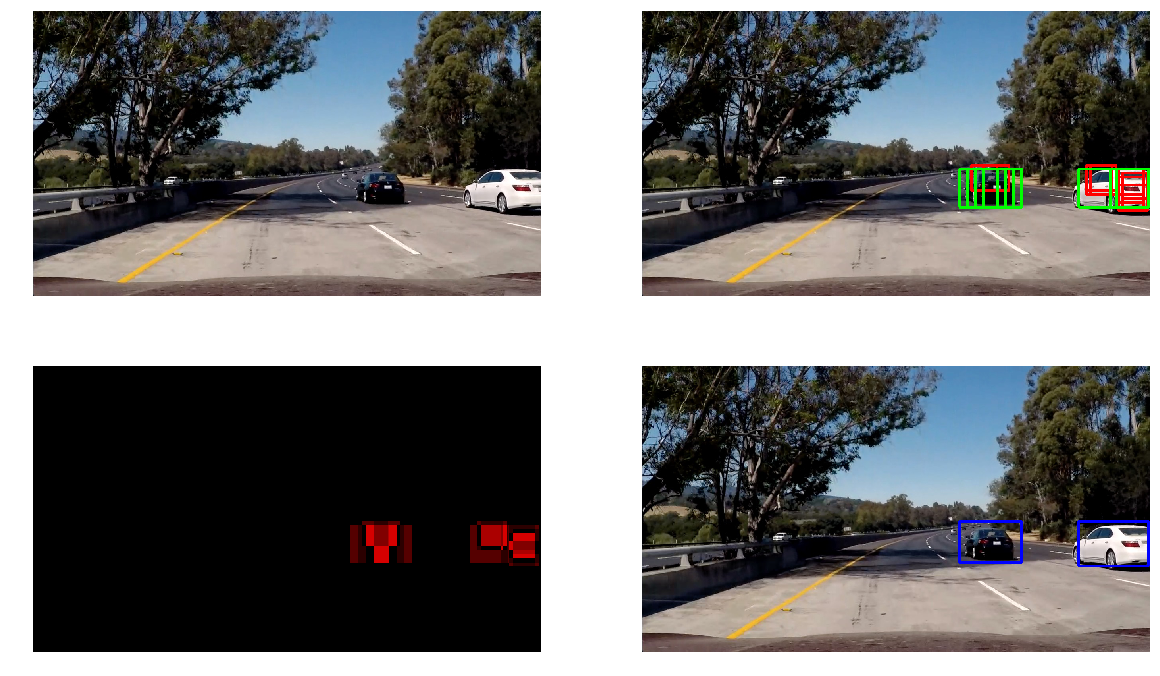

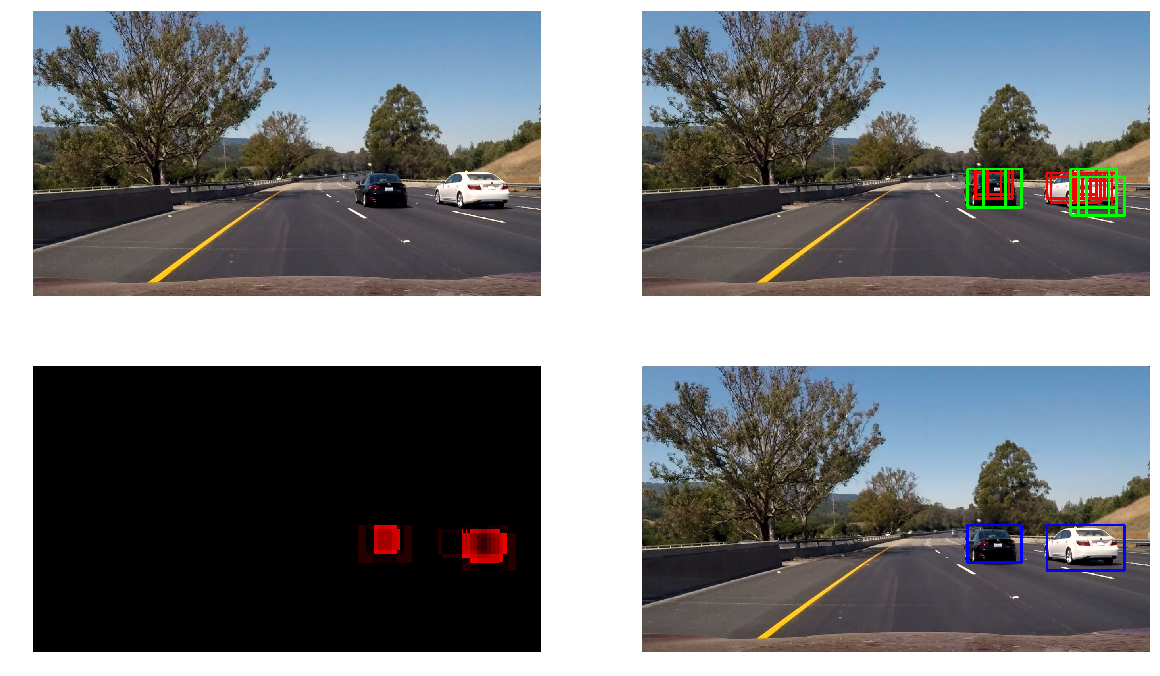

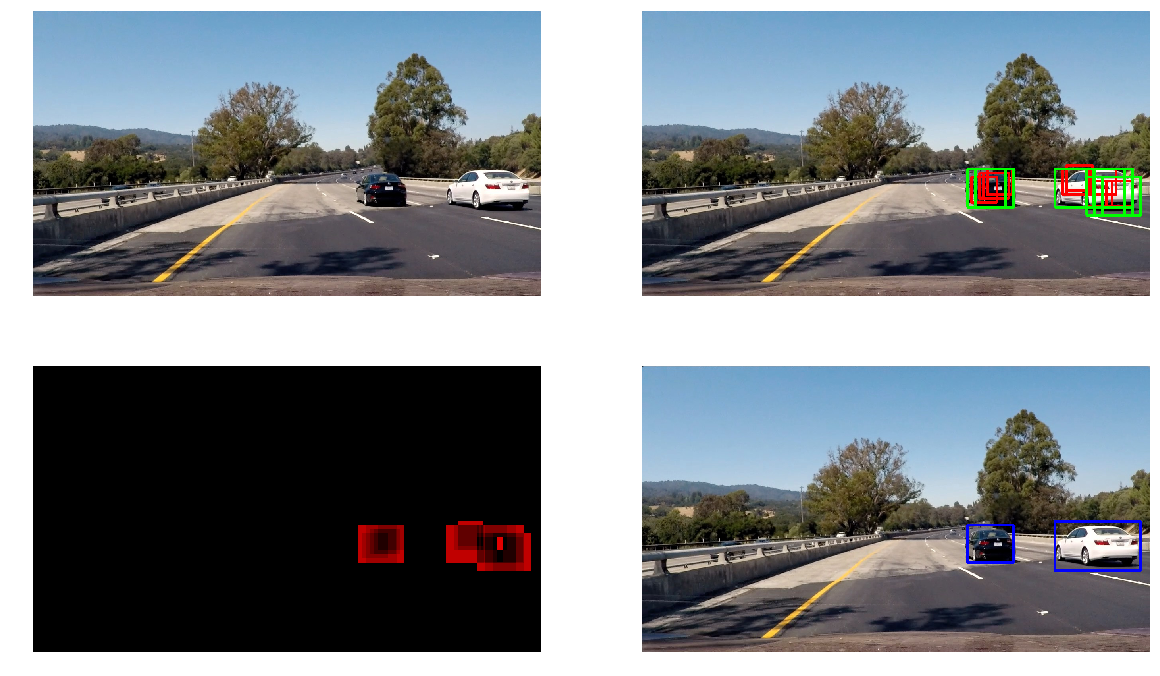

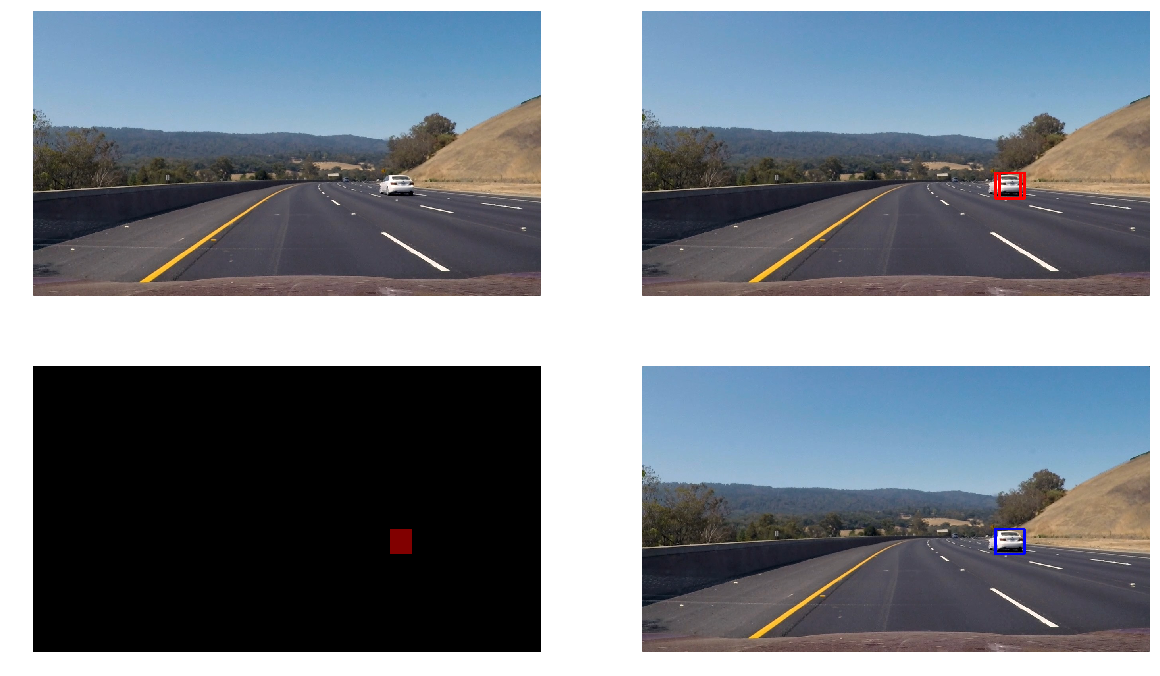

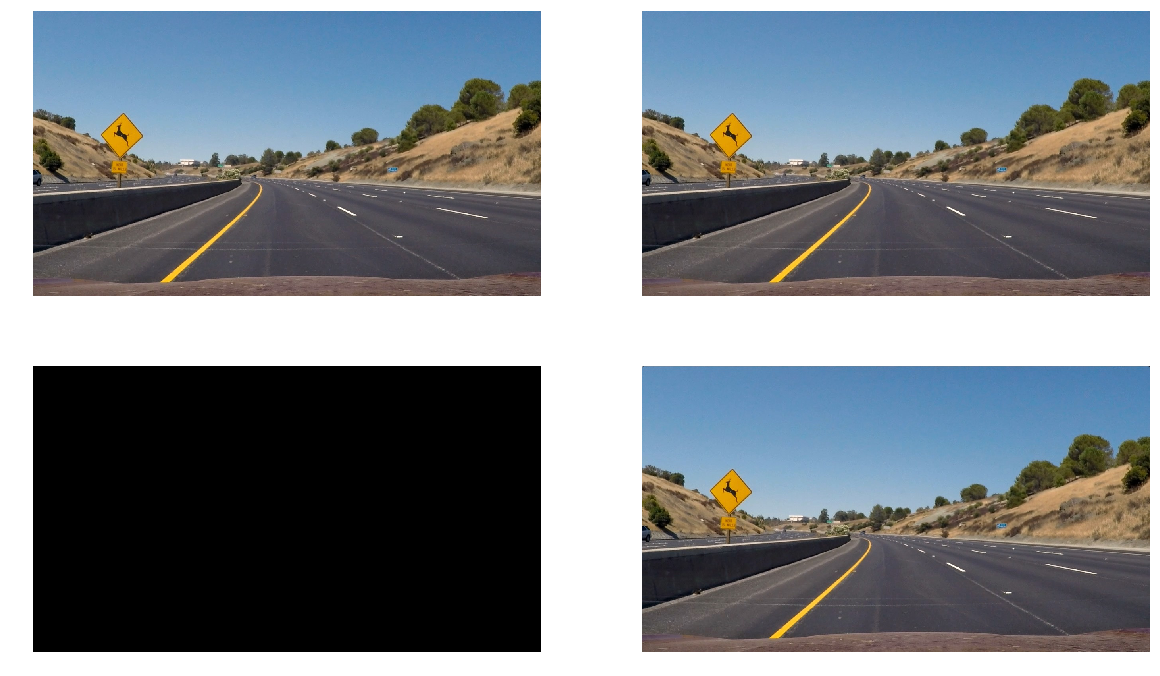

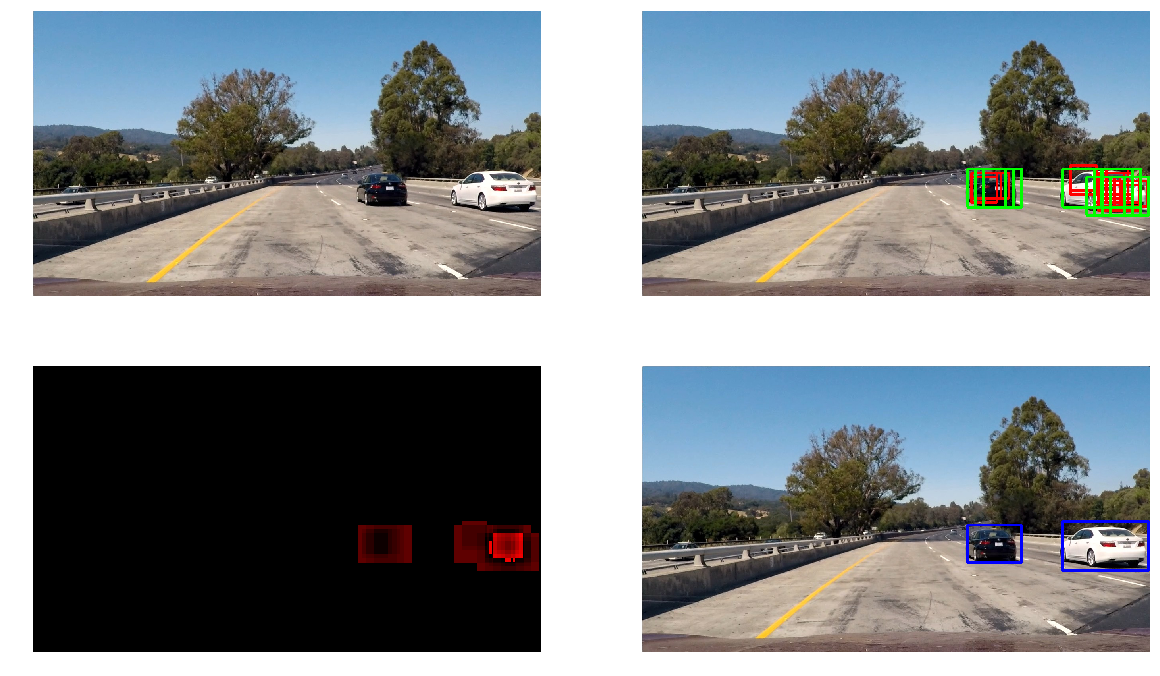

In [10]:
images = glob.glob("data/test_images/test*.jpg")
p= Pipeline()
for path in images:
    image = mpimg.imread(path)
    draw_img, heatmap, new_image = p.run(image)
    
    plt.figure(figsize=(20,12))
    plt.subplot(2,2,1)
    plt.axis("off")
    plt.imshow(image)
    plt.subplot(2,2,2)
    plt.axis("off")
    plt.imshow(new_image)
    plt.subplot(2,2,3)
    plt.axis("off")
    plt.imshow(heatmap*255/np.max(heatmap))
    plt.subplot(2,2,4)
    plt.axis("off")
    plt.imshow(draw_img)
    plt.savefig("data/report_images/" + path.split("/")[-1])  


   

## Video

In [54]:
video = "data/test_videos/project_video.mp4"

# Create VideoPipeline
pipeline = Pipeline()
    
# Read video
clip = VideoFileClip(video)
    
# Process video
clip_processed = clip.fl_image(pipeline.run)
    
# Save to disk
_,video_name = os.path.split(video)
out_name = os.path.join("data/report_images/", video_name)
clip_processed.write_videofile(out_name, audio=False)
    
# Display in the notebook
print(out_name)
display(HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(out_name)))

[MoviePy] >>>> Building video data/report_images/project_video.mp4
[MoviePy] Writing video data/report_images/project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<10:55,  1.92it/s]

  0%|          | 2/1261 [00:01<10:56,  1.92it/s]

  0%|          | 3/1261 [00:01<10:56,  1.92it/s]

  0%|          | 4/1261 [00:02<12:12,  1.71it/s]

  0%|          | 5/1261 [00:03<13:06,  1.60it/s]

  0%|          | 6/1261 [00:03<13:44,  1.52it/s]

  1%|          | 7/1261 [00:04<12:51,  1.62it/s]

  1%|          | 8/1261 [00:04<12:15,  1.70it/s]

  1%|          | 9/1261 [00:05<11:47,  1.77it/s]

  1%|          | 10/1261 [00:06<12:46,  1.63it/s]

  1%|          | 11/1261 [00:06<13:29,  1.54it/s]

  1%|          | 12/1261 [00:07<13:59,  1.49it/s]

  1%|          | 13/1261 [00:08<14:19,  1.45it/s]

  1%|          | 14/1261 [00:08<14:35,  1.42it/s]

  1%|          | 15/1261 [00:09<14:47,  1.40it/s]

  1%|▏         | 16/1261 [00:10<14:54,  1.39it/s]

  1%|▏         | 17/1261 [00:11<14:58,  1.38it/s]

  1%|▏         | 18/1261 [00:11<15:03,  1.38it/s]

  2%|▏         | 19/1261 [00:12<15:04,  1.37it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: data/report_images/project_video.mp4 

data/report_images/project_video.mp4
